# Titanic Data Set
From Kaggle Titanic - ML from Disaster competition

Streamlined code

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn import metrics

Data dictionary

Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd


sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## import and characterize the dataset

In [2]:
# import the training and testing data set

filename = 'train.csv'

train_df = pd.read_csv(filename)

filename2 = 'test.csv'

test_df = pd.read_csv(filename2)

In [5]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train_df.shape

(891, 12)

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# What are the data types
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
# How many of each column are missing
# get names of columsn with missing values

cols_with_missing = [col for col in train_df.columns
                    if train_df[col].isnull().any()]

print('Columns with missing values: ', cols_with_missing)

for x in cols_with_missing:
    print(x, ':', train_df[x].isna().sum())

Columns with missing values:  ['Age', 'Cabin', 'Embarked']
Age : 177
Cabin : 687
Embarked : 2


## set up pipeline

In [12]:
# Break training data into testing and training sets so we can test a random forest classifier


# target we are looking for is 'Survived'
y = train_df.Survived


# features = ['Pclass', 'Sex', 'SibSp', 'Age', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
# this is all of the features

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age']
#X = pd.get_dummies(train_df[features])
X = train_df[features]
#X_test = pd.get_dummies(test_df[features])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [13]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [14]:
# preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='most_frequent')

# preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [15]:
# define the model

model = RandomForestClassifier(n_estimators=350, max_depth=8, random_state=1)

In [16]:
# bundle preprocessing and moedling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', RandomForestClassifier())])

# preprocessing of training data, fit mode
my_pipeline.fit(X_train, y_train)

# preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)


print(metrics.accuracy_score(y_valid, preds))

0.770949720670391


## try a randomized search CV to isolate parameters of model

Based on: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [30]:
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

In [31]:
print(random_grid)

{'rf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'rf__max_features': ['auto', 'sqrt'], 'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1, 2, 4], 'rf__bootstrap': [True, False]}


In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


# Fit the random search model
#rf_random.fit(X_train, y_train)



# define the pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('rf', RandomForestRegressor())])

grid_pipeline = RandomizedSearchCV(my_pipeline, param_distributions = random_grid, 
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


#print(grid_pipeline.get_params().keys())

grid_pipeline.fit(X_train, y_train)

print(grid_pipeline.best_params_)

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocessor', 'estimator__rf', 'estimator__preprocessor__n_jobs', 'estimator__preprocessor__remainder', 'estimator__preprocessor__sparse_threshold', 'estimator__preprocessor__transformer_weights', 'estimator__preprocessor__transformers', 'estimator__preprocessor__verbose', 'estimator__preprocessor__num', 'estimator__preprocessor__cat', 'estimator__preprocessor__num__add_indicator', 'estimator__preprocessor__num__copy', 'estimator__preprocessor__num__fill_value', 'estimator__preprocessor__num__missing_values', 'estimator__preprocessor__num__strategy', 'estimator__preprocessor__num__verbose', 'estimator__preprocessor__cat__memory', 'estimator__preprocessor__cat__steps', 'estimator__preprocessor__cat__verbose', 'estimator__preprocessor__cat__imputer', 'estimator__preprocessor__cat__onehot', 'estimator__preprocessor__cat__imputer__add_indicator', 'estimator__preprocessor__cat__impute

In [33]:
grid_search_results = pd.DataFrame.from_dict(grid_pipeline.cv_results_)
grid_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.465815,0.003241,0.056282,0.007193,400,5,1,sqrt,30,True,"{'rf__n_estimators': 400, 'rf__min_samples_spl...",0.381963,0.445488,0.471116,0.432856,0.037477,51
1,2.254900,0.016472,0.163347,0.004566,2000,5,1,sqrt,10,True,"{'rf__n_estimators': 2000, 'rf__min_samples_sp...",0.388637,0.467932,0.478865,0.445145,0.040205,24
2,1.120405,0.020106,0.098107,0.001964,1200,5,2,sqrt,10,False,"{'rf__n_estimators': 1200, 'rf__min_samples_sp...",0.381238,0.444417,0.469845,0.431833,0.037252,54
3,2.460552,0.046719,0.139386,0.013671,2000,2,4,auto,30,False,"{'rf__n_estimators': 2000, 'rf__min_samples_sp...",0.325017,0.282704,0.355100,0.320940,0.029696,86
4,1.769551,0.030040,0.124112,0.006813,1600,2,4,sqrt,10,True,"{'rf__n_estimators': 1600, 'rf__min_samples_sp...",0.381203,0.485353,0.468696,0.445084,0.045680,25


<AxesSubplot:xlabel='param_rf__n_estimators', ylabel='param_rf__max_depth'>

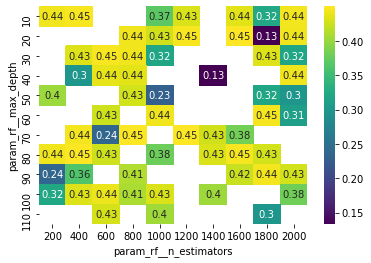

In [34]:
heatmap_data = pd.pivot_table(grid_search_results, values='mean_test_score',
                             index=['param_rf__max_depth'],
                             columns='param_rf__n_estimators')

sns.heatmap(heatmap_data, annot = True, cmap='viridis')